In [23]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nibabel as nib
import os
import re
import xml.etree.ElementTree as ET
from tqdm import tqdm
from scipy.stats import entropy
from skimage.exposure import histogram
import cv2
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import gc
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

/tmp/ipykernel_36/573148028.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [24]:
import numpy as np
import pandas as pd

metadata = '/kaggle/input/adni-processed-complete/ADNI1_Complete_1Yr_1.5T_6_20_2025.csv'
meta = pd.read_csv(metadata)
meta.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,NaN
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,NiFTI,NaN
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,NaN
3,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,NaN
4,I105437,941_S_1202,CN,M,79,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/28/2008,NiFTI,NaN


In [25]:
matching_index = meta[(meta['Image Data ID'] == 'I112538') & (meta['Subject'] == '941_S_1311')].index
matching_index

Index([0], dtype='int64')

In [26]:
meta.shape

(2294, 12)

In [27]:
import os

base_path = "/kaggle/input/adni-processed-complete/ADNI_Processed/ADNI_Processed"
subjects = []
for folder in os.listdir(base_path):
    print(folder)
    for subject in os.listdir(os.path.join(base_path, folder)):
        subjects.append(subject)

subjects = list(set(subjects))
l_s = len(subjects)
print("Total Subjects", l_s)

ADNI1_Complete 1Yr 1.5T8
ADNI1_Complete 1Yr 1.5T1
ADNI1_Complete 1Yr 1.5T6
ADNI1_Complete 1Yr 1.5T4
ADNI1_Complete 1Yr 1.5T9
ADNI1_Complete 1Yr 1.5T3
ADNI1_Complete 1Yr 1.5T5
ADNI1_Complete 1Yr 1.5T2
ADNI1_Complete 1Yr 1.5T
ADNI1_Complete 1Yr 1.5T7
Total Subjects 639


In [28]:
import random

random.shuffle(subjects)
train_subjects = subjects[:int(0.7*l_s)]
val_subjects = subjects[int(0.7*l_s):int(0.8*l_s)]
test_subjects = subjects[int(0.8*l_s):]

In [29]:
train_file_paths = []
val_file_paths = []
test_file_paths = []

train_targets = []
val_targets = []
test_targets = []

for folder in os.listdir(base_path):
    print(folder)
    for subject in os.listdir(os.path.join(base_path, folder)):
        for image in os.listdir(os.path.join(base_path, folder, subject)):
            for file in os.listdir(os.path.join(base_path, folder, subject, image)):
                file_path = os.path.join(base_path, folder, subject, image, file)
                target_idx = meta[((meta['Subject'] == subject) & (meta['Image Data ID'] == image))].index
                label_str = str(meta.iloc[target_idx[0], 2])
                if label_str == 'MCI':
                    continue
                if subject in train_subjects:
                    train_file_paths.append((label_str, file_path))
                elif subject in val_subjects:
                    val_file_paths.append((label_str, file_path))
                elif subject in test_subjects:
                    test_file_paths.append((label_str, file_path))
                else:
                    print("Error Subject not in any split")

ADNI1_Complete 1Yr 1.5T8
ADNI1_Complete 1Yr 1.5T1
ADNI1_Complete 1Yr 1.5T6
ADNI1_Complete 1Yr 1.5T4
ADNI1_Complete 1Yr 1.5T9
ADNI1_Complete 1Yr 1.5T3
ADNI1_Complete 1Yr 1.5T5
ADNI1_Complete 1Yr 1.5T2
ADNI1_Complete 1Yr 1.5T
ADNI1_Complete 1Yr 1.5T7


In [30]:
print(len(train_file_paths))
print(len(val_file_paths))
print(len(test_file_paths))
# file_paths -> contains paths of all files
# targets -> corresponding targets (in the same order as file_paths)

842
122
217


In [31]:
def center_crop(image, crop_size=128):
    h, w = image.shape
    if h < crop_size or w < crop_size:
        return None
    top = (h - crop_size) // 2
    left = (w - crop_size) // 2
    return image[top:top+crop_size, left:left+crop_size]

def image_entropy(img):
    hist, _ = histogram(img)
    hist = hist / np.sum(hist)
    return entropy(hist, base=2)

In [32]:
class EntropySlicesDataset(Dataset):
    def __init__(self, actual_paths, N=100, crop_size=128, transform=None):
        """
        Args:
            actual_paths: list of tuples (label_str, path_to_nifti)
            N: number of top entropy slices per subject
            crop_size: center crop size
            transform: optional torchvision transforms on the final subject_volume tensor
        """
        self.actual_paths = actual_paths
        self.N = N
        self.crop_size = crop_size
        self.transform = transform
        self.samples = self._filter_valid_subjects()

    def _filter_valid_subjects(self):
        """
        Pre-screen subjects to exclude those with fewer than N slices.
        Returns a list of (label_val, path) tuples that have enough slices.
        """
        valid = []
        print("Pre-scanning subjects to exclude insufficient-slice cases...")
        for label, path in tqdm(self.actual_paths):
            scan = nib.load(path)
            data = scan.get_fdata()
            slice_info = []

            for axis in [0, 1, 2]:
                for i in range(data.shape[axis]):
                    if axis == 0:
                        slice_ = data[i, :, :]
                    elif axis == 1:
                        slice_ = data[:, i, :]
                    else:
                        slice_ = data[:, :, i]

                    cropped = center_crop(slice_, crop_size=self.crop_size)
                    if cropped is None:
                        continue

                    ent = image_entropy(cropped)
                    slice_info.append((ent,))  # Only entropy needed for counting

            if len(slice_info) >= self.N:
                valid.append((label, path))
            else:
                print(f"[!] Skipped subject at {path}: only {len(slice_info)} valid slices")
        return valid

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label_str, path = self.samples[idx]
        scan = nib.load(path)
        data = scan.get_fdata()
        label_val = 0 if label_str == 'AD' else 1

        slice_info = []
        for axis in [0, 1, 2]:
            for i in range(data.shape[axis]):
                if axis == 0:
                    slice_ = data[i, :, :]
                elif axis == 1:
                    slice_ = data[:, i, :]
                else:
                    slice_ = data[:, :, i]

                cropped = center_crop(slice_, crop_size=self.crop_size)
                if cropped is None:
                    continue

                ent = image_entropy(cropped)
                slice_info.append((ent, cropped))

        slice_info.sort(reverse=True, key=lambda x: x[0])
        top_slices = slice_info[:self.N]

        subject_slices = []
        for _, slice_2d in top_slices:
            slice_2d = slice_2d[..., np.newaxis]                   # (128,128,1)
            slice_rgb = np.repeat(slice_2d, 3, axis=-1)            # (128,128,3)
            slice_rgb_chw = np.transpose(slice_rgb, (2, 0, 1))     # (3,128,128)
            subject_slices.append(slice_rgb_chw)

        subject_volume = np.stack(subject_slices, axis=0)          # (N,3,128,128)

        subject_volume = torch.from_numpy(subject_volume).float()  # convert to torch tensor

        if self.transform:
            subject_volume = self.transform(subject_volume)

        return subject_volume, label_val

In [33]:
train_dataset = EntropySlicesDataset(train_file_paths, N=100, crop_size=128)
val_dataset   = EntropySlicesDataset(val_file_paths, N=100, crop_size=128)
test_dataset  = EntropySlicesDataset(test_file_paths, N=100, crop_size=128)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

Pre-scanning subjects to exclude insufficient-slice cases...


100%|██████████| 842/842 [11:33<00:00,  1.21it/s]


Pre-scanning subjects to exclude insufficient-slice cases...


100%|██████████| 122/122 [01:48<00:00,  1.12it/s]


Pre-scanning subjects to exclude insufficient-slice cases...


100%|██████████| 217/217 [03:18<00:00,  1.10it/s]


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ResNetPerSlice(nn.Module):
    def __init__(self, dropout_p=0.3):
        super().__init__()
        resnet = models.resnet152(weights='IMAGENET1K_V1')
        modules = list(resnet.children())[:-2]  # keep feature maps before final pool
        self.features = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout2d(p=dropout_p)  # spatial dropout

    def forward(self, x):
        x = self.features(x)         # (B, 2048, H', W')
        x = self.dropout(x)
        x = self.pool(x)             # (B, 2048, 1, 1)
        x = self.flatten(x)          # (B, 2048)
        return x

class AttentionXAIClassifier(nn.Module):
    def __init__(self, feature_dim=2048, attn_hidden=128, num_classes=1, dropout_p=0.5):
        super().__init__()
        self.cnn_per_slice = ResNetPerSlice(dropout_p=0.3)

        # Attention module → use LayerNorm instead of BatchNorm1d
        self.attn_fc = nn.Sequential(
            nn.Linear(feature_dim, attn_hidden, bias=False),
            nn.LayerNorm(attn_hidden),     # ← swapped
            nn.Tanh(),
            nn.Dropout(p=dropout_p),
            nn.Linear(attn_hidden, 1)
        )

        # Classifier head → also use LayerNorm
        self.classifier_fc = nn.Sequential(
            nn.Linear(feature_dim, 128, bias=False),
            nn.LayerNorm(128),             # ← swapped
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(128, num_classes)    # num_classes=1 for BCEWithLogits
        )

    def forward(self, x, noise_p=0.01):
        B, N, C, H, W = x.shape

        # optional: inject tiny gaussian noise to inputs
        if self.training and noise_p>0:
            x = x + torch.randn_like(x) * noise_p

        x = x.view(B * N, C, H, W)
        features = self.cnn_per_slice(x)         # (B*N, 2048)
        features = features.view(B, N, -1)       # (B, N, 2048)

        # compute attention scores
        w = self.attn_fc(features.view(-1, features.size(-1)))  # (B*N, 1)
        w = w.view(B, N)                                        # (B, N)
        alpha = F.softmax(w, dim=1).unsqueeze(-1)                # (B, N, 1)

        # weighted pooling
        pooled = torch.sum(alpha * features, dim=1)             # (B, 2048)
        logits = self.classifier_fc(pooled)                    # (B, num_classes)

        return logits, alpha

In [37]:
def train(model, train_loader, val_loader, device, num_epochs=10, lr=1e-4):
    # — compute class imbalance from train_loader —
    all_labels = []
    for _, y in train_loader:
        all_labels.append(y)
    all_labels = torch.cat(all_labels).to(device)
    neg_count = (all_labels == 0).sum().float()
    pos_count = (all_labels == 1).sum().float()
    pos_weight = torch.tensor([neg_count / pos_count], device=device)

    # 1) Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # 2) LR scheduler (reduce on plateau of val_loss) — drop verbose=True
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
    
    # 3) Criterion (with computed pos_weight)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # 4) Label‑smoothing factor
    eps = 0.1

    scaler = GradScaler()
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        # ----------------
        # Training phase
        # ----------------
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]")

        for X, y in pbar:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            optimizer.zero_grad()

            with autocast():
                outputs, _ = model(X)
                outputs = outputs.squeeze(1)
                # manual label smoothing
                targets_s = y.float() * (1 - eps) + 0.5 * eps
                loss = criterion(outputs, targets_s)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss    += loss.item() * X.size(0)
            probs          = torch.sigmoid(outputs)
            preds          = (probs > 0.5).long()
            train_correct += (preds == y.long()).sum().item()
            total         += y.size(0)

            pbar.set_postfix(loss=loss.item(), acc=100 * train_correct / total)
            del outputs, loss, probs, preds, targets_s

        avg_train_loss = train_loss / total
        train_acc      = 100 * train_correct / total

        # ------------------
        # Validation phase
        # ------------------
        model.eval()
        val_loss, val_correct, total_val = 0.0, 0, 0

        with torch.no_grad(), autocast():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device, non_blocking=True), y_val.to(device, non_blocking=True)
                outputs, _ = model(X_val)
                outputs = outputs.squeeze(1)
                targets_s = y_val.float() * (1 - eps) + 0.5 * eps
                loss = criterion(outputs, targets_s)

                val_loss    += loss.item() * X_val.size(0)
                probs        = torch.sigmoid(outputs)
                preds        = (probs > 0.5).long()
                val_correct += (preds == y_val.long()).sum().item()
                total_val   += y_val.size(0)

                del outputs, loss, probs, preds, targets_s

        avg_val_loss = val_loss / total_val
        val_acc      = 100 * val_correct / total_val

        print(f"Epoch {epoch:02d}: "
              f"Train Loss {avg_train_loss:.4f} Acc {train_acc:.2f}%, "
              f"Val Loss {avg_val_loss:.4f} Acc {val_acc:.2f}%")

        # — Step the LR scheduler on validation loss (no verbose flag) —
        scheduler.step(avg_val_loss)


In [38]:
model = AttentionXAIClassifier(num_classes=1) # adjust num_classes if binary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)

model.to(device) 

train(model, train_loader, test_loader, device, num_epochs=10)

Using 2 GPUs


/tmp/ipykernel_36/3127691956.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]/tmp/ipykernel_36/3127691956.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10 [Train]: 100%|██████████| 211/211 [05:37<00:00,  1.60s/it, acc=62.4, loss=0.444]
/tmp/ipykernel_36/3127691956.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 01: Train Loss 0.5220 Acc 62.35%, Val Loss 0.7238 Acc 34.56%


Epoch 2/10 [Train]: 100%|██████████| 211/211 [05:35<00:00,  1.59s/it, acc=77.1, loss=0.303]


Epoch 02: Train Loss 0.4472 Acc 77.08%, Val Loss 0.3726 Acc 82.95%


Epoch 3/10 [Train]: 100%|██████████| 211/211 [05:32<00:00,  1.58s/it, acc=84.6, loss=0.245]


Epoch 03: Train Loss 0.3883 Acc 84.56%, Val Loss 0.6847 Acc 57.60%


Epoch 4/10 [Train]: 100%|██████████| 211/211 [05:26<00:00,  1.55s/it, acc=91.8, loss=0.27] 


Epoch 04: Train Loss 0.2952 Acc 91.81%, Val Loss 0.3353 Acc 88.02%


Epoch 5/10 [Train]: 100%|██████████| 211/211 [05:33<00:00,  1.58s/it, acc=95.1, loss=0.165]


Epoch 05: Train Loss 0.2439 Acc 95.13%, Val Loss 0.3527 Acc 85.25%


Epoch 6/10 [Train]: 100%|██████████| 211/211 [05:32<00:00,  1.57s/it, acc=96.8, loss=0.182]


Epoch 06: Train Loss 0.2230 Acc 96.79%, Val Loss 0.7432 Acc 57.14%


Epoch 7/10 [Train]: 100%|██████████| 211/211 [05:30<00:00,  1.57s/it, acc=98.6, loss=0.163]


Epoch 07: Train Loss 0.1976 Acc 98.57%, Val Loss 0.4608 Acc 76.96%


Epoch 8/10 [Train]: 100%|██████████| 211/211 [05:26<00:00,  1.55s/it, acc=99.2, loss=0.18] 


Epoch 08: Train Loss 0.1859 Acc 99.17%, Val Loss 0.4211 Acc 82.95%


Epoch 9/10 [Train]: 100%|██████████| 211/211 [05:32<00:00,  1.58s/it, acc=99.3, loss=0.165]


Epoch 09: Train Loss 0.1855 Acc 99.29%, Val Loss 0.3683 Acc 84.33%


Epoch 10/10 [Train]: 100%|██████████| 211/211 [05:35<00:00,  1.59s/it, acc=100, loss=0.187]


Epoch 10: Train Loss 0.1753 Acc 100.00%, Val Loss 0.3856 Acc 84.79%


In [39]:
torch.save(model.state_dict(), "axial_weights.pth")

In [45]:
model.eval()  # set model to evaluation mode
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs, _ = model(X)          # outputs: logits of shape (B,1)
        outputs = outputs.squeeze(1)   # (B,)

        probs = torch.sigmoid(outputs)   # get probabilities
        preds = (probs > 0.5).long()     # binary thresholding

        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())
        all_labels.append(y.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Create classification report
print(classification_report(all_labels, all_preds, target_names=["AD", "CN"]))

              precision    recall  f1-score   support

          AD       0.72      0.91      0.80        75
          CN       0.94      0.82      0.88       142

    accuracy                           0.85       217
   macro avg       0.83      0.86      0.84       217
weighted avg       0.87      0.85      0.85       217



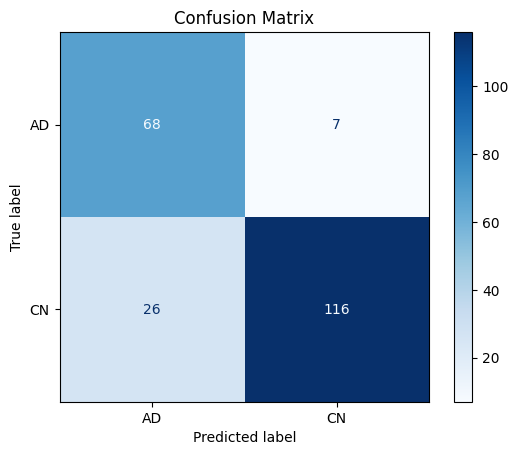

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optional: normalize='true' for percentage matrix
# cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AD", "CN"])
disp.plot(cmap="Blues", values_format='d')  # use '.2f' for float % if normalized
plt.title("Confusion Matrix")
plt.show()

In [42]:
acc = (all_preds == all_labels).mean()
print(f"\nOverall Test Accuracy: {acc*100:.2f}%")


Overall Test Accuracy: 84.79%


In [ ]:
'''
train_dataset = ScanDataset(X_train, y_train)
test_dataset  = ScanDataset(X_test, y_test)
'''

In [ ]:
'''
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)
'''

In [ ]:
'''
class TimeDistributedResNet(nn.Module):
    def __init__(self, base_model):
        super(TimeDistributedResNet, self).__init__()
        self.base_model = base_model

    def forward(self, x):
        # x: (batch, time, 3, 128,128)
        B, T, C, H, W = x.size()
        x = x.view(B*T, C, H, W)
        x = self.base_model(x)                   # (B*T, 2048)
        x = x.view(B, T, -1)                     # (B, T, 2048)
        return x

class ScanLSTMClassifier(nn.Module):
    def __init__(self):
        super(ScanLSTMClassifier, self).__init__()
        base_resnet = models.resnet152(weights='IMAGENET1K_V1')
        base_resnet.fc = nn.Identity()
        self.resnet = TimeDistributedResNet(base_resnet)

        for param in self.resnet.parameters():
            param.requires_grad = False          # freeze ResNet

        self.lstm = nn.LSTM(2048, 512, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.resnet(x)                       # (B, T, 2048)
        _, (hn, _) = self.lstm(x)                # hn: (1, B, 256)
        x = hn.squeeze(0)                        # (B, 256)
        x = F.relu(self.fc1(x))                  # (B, 128)
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x)).squeeze(-1)  # (B,)
        return x
'''

In [ ]:
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = ScanLSTMClassifier().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-6)
'''

In [ ]:
'''
class ScanDataset(Dataset):
    def __init__(self, scans, labels):
        self.scans = scans
        self.labels = labels

    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        x = self.scans[idx]  # shape: (100, 3, 128, 128)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
'''

In [ ]:
'''
N = 100  # number of entropy-based slices
crop_size = 128

X, y = [], []

for label, path in tqdm(actual_paths):
    scan = nib.load(path)
    data = scan.get_fdata()
    label_val = 0 if label == 'AD' else 1

    slice_info = []

    for axis in [0, 1, 2]:  
        for i in range(data.shape[axis]):
            # Extract 2D slice along the given axis 
            if axis == 0:
                slice_ = data[i, :, :]
            elif axis == 1:
                slice_ = data[:, i, :]
            else:
                slice_ = data[:, :, i]

            # Crop and skip empty slices
            cropped = center_crop(slice_, crop_size=crop_size)
            if cropped is None:
                continue

            # Compute entropy
            ent = image_entropy(cropped)
            slice_info.append((ent, cropped))

    # Sort slices by entropy
    slice_info.sort(reverse=True, key=lambda x: x[0])
    top_slices = slice_info[:N]

    if len(top_slices) < N:
        print(f"[!] Skipped subject: only {len(top_slices)} slices")
        continue

    subject_slices = []

    for _, slice_2d in top_slices:
        # Grayscale slice is (128,128), add channel axis → (128,128,1)
        slice_2d = slice_2d[..., np.newaxis]

        # Repeat channel 3 times → (128,128,3)
        slice_rgb = np.repeat(slice_2d, 3, axis=-1)

        # Convert to channels-first → (3,128,128)
        slice_rgb_chw = np.transpose(slice_rgb, (2,0,1))

        subject_slices.append(slice_rgb_chw)

    # Stack into (N,3,128,128)
    subject_volume = np.stack(subject_slices, axis=0)

    X.append(subject_volume)
    y.append(label_val)

X = np.stack(X)  # shape: (num_subjects, N, 128, 128, 1)
y = np.array(y)  # shape: (num_subjects,)

'''